# ML in Cybersecurity: Task II

## Team
  * **Team name**:  SaS
  * **Members**:  Aleeza Suhel Inamdar (alin00002@stud.uni-saarland.de), Shantanu Kumar Rahut (shra00001@stud.uni-saarland.de), Shashank Priyadarshi (shpr00001@stud.uni-saarland.de)


## Logistics
  * **Due date**: 26th Dec. 2023, 23:59:59 (email the completed notebook including outputs to raouf.kerkouche@cispa.de)
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.


## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it).

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.


  ---

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt

import json
import time
import pickle
import sys
import csv
import os
import os.path as osp
import shutil

import pandas as pd

from IPython.display import display, HTML

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [ ]:
compute_mode = 'gpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data

Load the MNIST data, as done in task 1.

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

In [ ]:
# (1)load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# (2)define model
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# (3)define loss, optimizer
model = MNISTCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# (4)train (You can re-use the trained model from project1)
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = correct_train / total_train
    average_loss = running_loss / len(train_loader)

# (5)evaluate
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = correct / total
print('Epoch %d, Train acc: %f, Test acc: %f' % (epoch, train_acc, test_acc))

100%|██████████| 9912422/9912422 [00:00<00:00, 271704709.54it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44584355.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 160536011.99it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10536796.88it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4, Train acc: 0.994033, Test acc: 0.989500


## 1.2: Implementing the FGSM attack

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example.

Please implement the FGSM attack mentioned in the lecture.

More details: https://arxiv.org/pdf/1412.6572.pdf


In [ ]:
def fgsm(model, X, y, epsilon=0.1):
    X.requires_grad = True
    model.zero_grad()
    output = model(X)
    loss = nn.CrossEntropyLoss()(output, y)
    loss.backward()
    perturbation = epsilon * torch.sign(X.grad.detach())
    perturbed_X = X + perturbation

    return perturbed_X

## 1.3: Adversarial sample set

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each.
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set.

In [ ]:
import time
eps = [0.05, 0.1, 0.25]
attacked_ds = {}
accuracy_attacked = {}
model = model.to(device)
for epsilon in eps:
  perturbed_images_epsilon = []
  success_rate_epsilon = 0.0
  correct = 0
  total = 0
  time_arr = []
  for images, labels in tqdm(test_loader, desc=f'Epsilon = {epsilon}'):
      images, labels = images.to(device), labels.to(device)
      perturbed_image = fgsm(model, images, labels, epsilon)
      perturbed_prediction = model(perturbed_image)
      perturbed_image = torch.clamp(perturbed_image.squeeze(), 0, 1)
      perturbed_images_epsilon.append(perturbed_image)
      _, predicted = torch.max(perturbed_prediction.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  accuracy_attacked[epsilon] = accuracy
  print(f'Epsilon={epsilon}, Accuracy: {accuracy * 100:.2f}%')
  attacked_ds[epsilon] = perturbed_images_epsilon

Epsilon = 0.05: 100%|██████████| 157/157 [00:03<00:00, 44.03it/s]


Epsilon=0.05, Accuracy: 97.27%


Epsilon = 0.1: 100%|██████████| 157/157 [00:03<00:00, 51.16it/s]


Epsilon=0.1, Accuracy: 93.81%


Epsilon = 0.25: 100%|██████████| 157/157 [00:04<00:00, 39.18it/s]

Epsilon=0.25, Accuracy: 63.77%


## 1.4: Visualizing the results

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


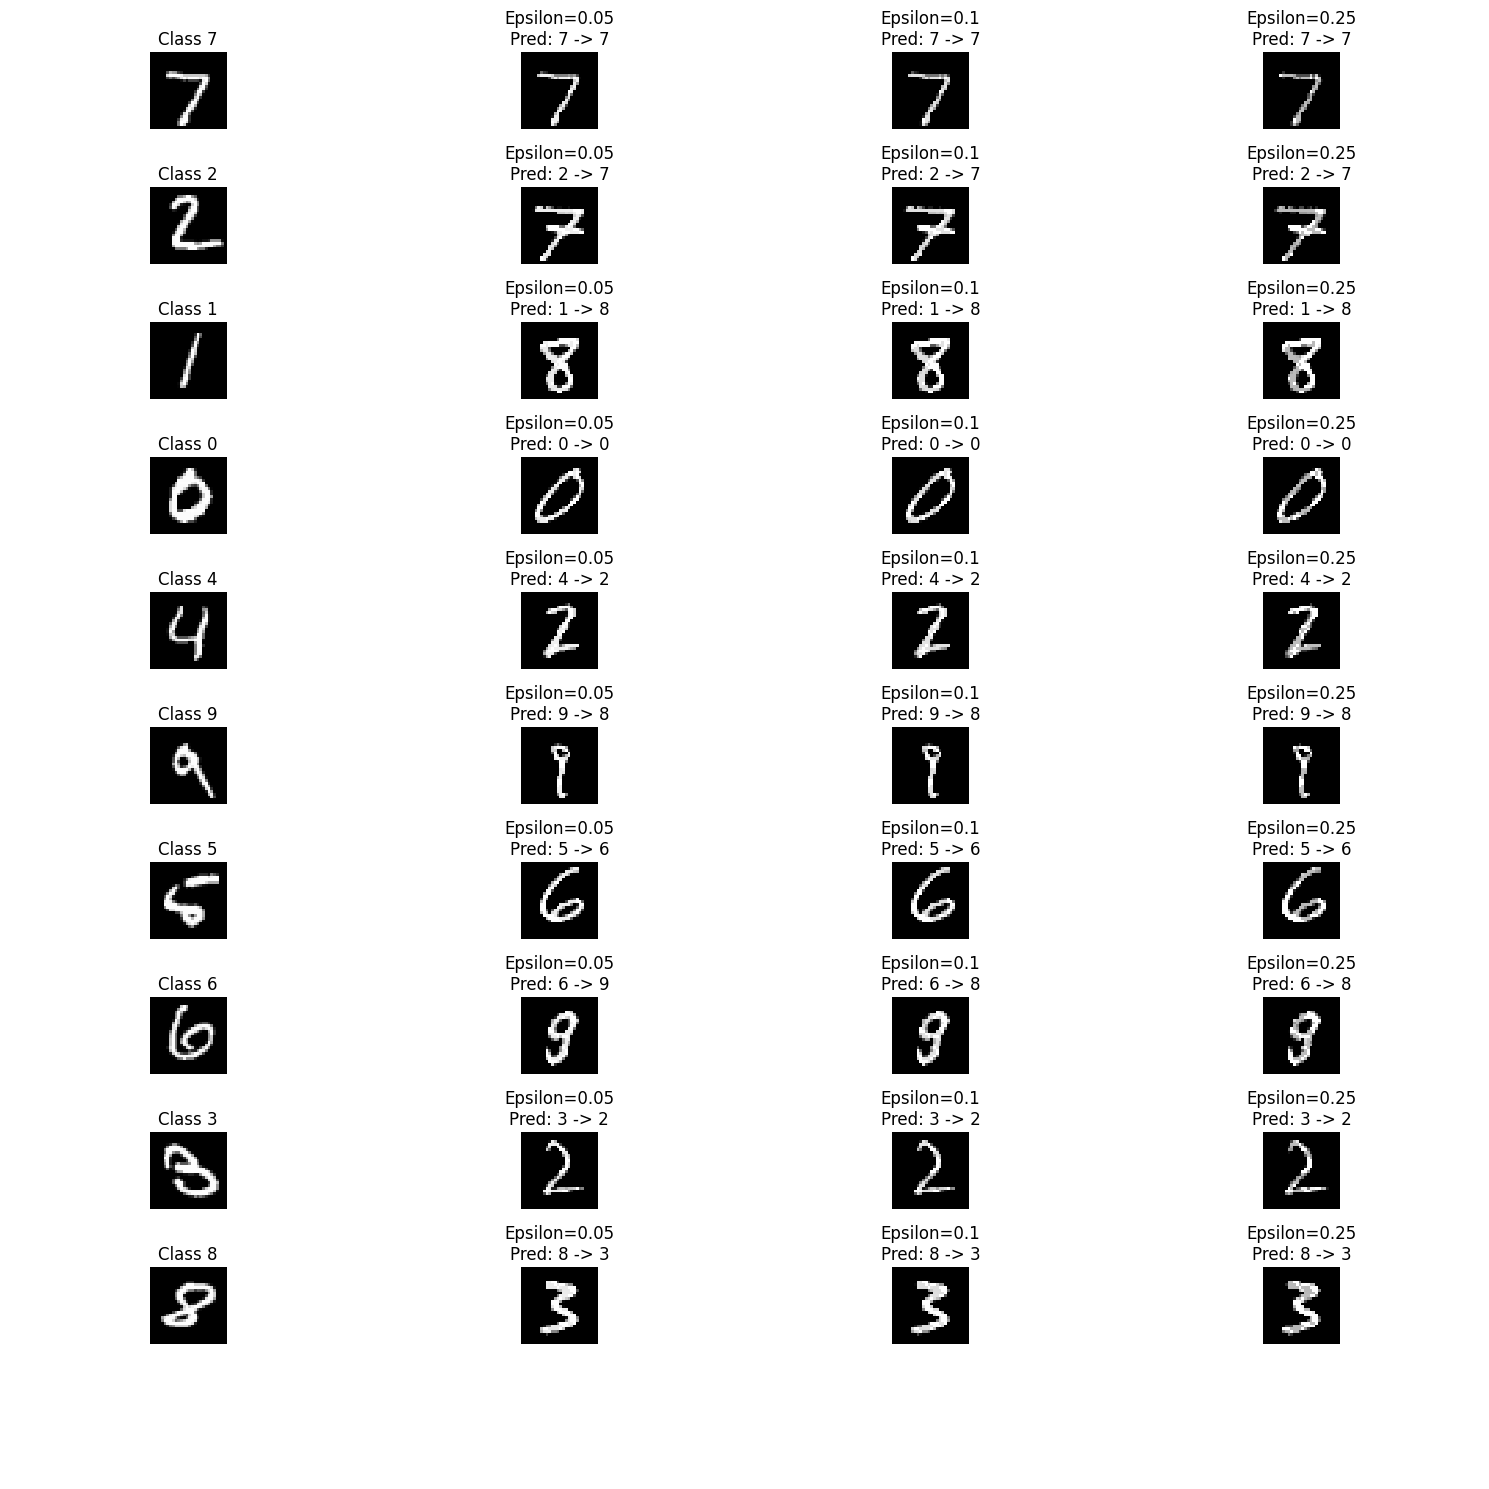

In [ ]:
def visualize_samples(ax, images, predictions, title):
    ax.imshow(np.transpose(torchvision.utils.make_grid(images, padding=5, normalize=True), (1, 2, 0)))
    ax.set_title(title, fontdict={'fontsize': 18, 'color': 'b'})
    ax.axis('off')
class_samples = {}
for images, labels in test_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if label not in class_samples:
            class_samples[label] = images[i]
        if len(class_samples) == 10:
            break
    if len(class_samples) == 10:
        break

fig, axes = plt.subplots(11, len(attacked_ds) + 1, figsize=(15, 15))
[ax.set_axis_off() for ax in axes.ravel()]

for i, (label, image) in enumerate(class_samples.items()):
    axes[i, 0].imshow(np.transpose(torchvision.utils.make_grid(image.unsqueeze(0), normalize=True).numpy(), (1, 2, 0)))
    axes[i, 0].set_title(f'Class {label}')
    axes[i, 0].axis('off')
model = model.cpu()
for j, (epsilon, (perturbed_images)) in enumerate(attacked_ds.items()):
    for i, (label, original_image) in enumerate(class_samples.items()):
        perturbed_image_batch = perturbed_images[i]
        perturbed_image = perturbed_image_batch[0].cpu().detach().numpy()

        axes[i, j + 1].imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(perturbed_image).unsqueeze(0), normalize=True).numpy(), (1, 2, 0)))
        axes[i, j + 1].set_title(f'Epsilon={epsilon}\nPred: {model(original_image.unsqueeze(0)).argmax().item()} -> {model(torch.from_numpy(perturbed_image).unsqueeze(0)).argmax().item()}')
        axes[i, j + 1].axis('off')

plt.tight_layout()
plt.show()


## 1.5: Analyzing the results

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second)
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations



*   No the attack on always succeed, it depends on input and how well the models understands it, we can increase the peturbation budget to increase the noise in the sample to make the model succeed in the attack. Attack success rate increases on increaseing the perturbation budget.
* On an average it takes around 0.00406seconds
* Yeah FGSM is an white box attack

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model.


## 2.1: Implementing the adversarial training defense

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture.

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples).

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before.

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


In [ ]:
robust_model = MNISTCNN()
robust_model = robust_model.to(device)
epsilon = 0.15
criterion_robust = nn.CrossEntropyLoss()
optimizer_robust = optim.Adam(robust_model.parameters(), lr=0.001)
for epoch in range(epochs):
    robust_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True
        perturbed_inputs = fgsm(robust_model, inputs, labels, epsilon)
        perturbed_outputs = robust_model(perturbed_inputs)
        perturbed_loss = criterion_robust(perturbed_outputs, labels)
        optimizer_robust.zero_grad()
        perturbed_loss.backward()
        optimizer_robust.step()

        running_loss += loss.item()

        _, predicted = torch.max(perturbed_outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = correct_train / total_train
    average_loss = running_loss / len(train_loader)

print ('Training Accuracy:', train_acc)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training Accuracy: 0.9745833333333334


## 2.2: Evaluation

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM.
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training.
    * You can use two values of epsilons from question 1.3
    
* Evaluate the **defended** model on these two adversarial examples sets.


In [ ]:
eps = [0.1, 0.25]
attack_datasets_robust = {}
accuracy_robust = {}
robust_model.eval()
for epsilon in eps:
  perturbed_images_epsilon = []
  success_rate_epsilon = 0.0
  correct = 0
  total = 0
  for images, labels in tqdm(test_loader, desc=f'Epsilon = {epsilon}'):
      images, labels = images.to(device), labels.to(device)
      perturbed_image = fgsm(robust_model, images, labels, epsilon)
      perturbed_prediction = robust_model(perturbed_image)
      perturbed_image = torch.clamp(perturbed_image.squeeze(), 0, 1)
      perturbed_images_epsilon.append(perturbed_image)
      _, predicted = perturbed_prediction.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  accuracy_robust[epsilon] = accuracy
  attack_datasets_robust[epsilon] = perturbed_images_epsilon
print ()
print('Accuracy on the lower-budget adversarial samples (FGSM) %.2f'%accuracy_attacked[0.1])
print('Accuracy on the lower-budget adversarial samples (FGSM) after defense %.2f'%accuracy_robust[0.1])

print('Accuracy on the higher-budget adversarial samples (FGSM) %.2f'%accuracy_attacked[0.25])
print('Accuracy on the higher-budget adversarial samples (FGSM) after defense %.2f'%accuracy_robust[0.25])

Epsilon = 0.25: 100%|██████████| 157/157 [00:02<00:00, 61.07it/s]


Accuracy on the lower-budget adversarial samples (FGSM) 0.94
Accuracy on the lower-budget adversarial samples (FGSM) after defense 0.98
Accuracy on the higher-budget adversarial samples (FGSM) 0.64
Accuracy on the higher-budget adversarial samples (FGSM) after defense 0.94


## 2.3 Discussion

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

* The defense successfully improved the robustness of model against the FGSM attack.
* The two sets differ based on the perturbation budget, and if we compare the overall accuracy then the defended model performs better in both the scenario.

# 3: I-FGSM attack

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed.
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack.



## 3.1: Implementing the I-FGSM attack

**Hints**:

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [ ]:
def ifgsm(model, X, y, epsilon=0.1, alpha=0.01, num_iterations=10):
    perturbed_X = X.clone().detach().requires_grad_(True)

    for _ in range(num_iterations):
        model.zero_grad()
        loss = nn.CrossEntropyLoss()(model(perturbed_X), y)
        loss.backward()
        perturbation = alpha * perturbed_X.grad.detach().sign()
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        perturbed_X.data = perturbed_X.data + perturbation
        perturbed_X.grad.zero_()
    return perturbed_X

## 3.2: Attack the undefended model

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison.

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented.

* Please compute the accuracy of the adversarial set on the **undefended** model.

In [ ]:
eps = [0.1]
attack_datasets_ifgsm_attacked = {}
accuracy_ifgsm_attacked = {}
model = model.to(device)
iterations_arr = [10, 20]
for num_iter in iterations_arr:
  for epsilon in eps:
    perturbed_images_epsilon = []
    success_rate_epsilon = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader, desc=f'Epsilon = {epsilon}'):
        images, labels = images.to(device), labels.to(device)
        perturbed_image = ifgsm(model, images, labels, epsilon, num_iterations = num_iter)
        perturbed_prediction = model(perturbed_image)
        perturbed_image = torch.clamp(perturbed_image.squeeze(), 0, 1)
        perturbed_images_epsilon.append(perturbed_image)
        _, predicted = torch.max(perturbed_prediction.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracy_ifgsm_attacked[epsilon] = accuracy
    print(f'Num of iterations used={num_iter} Epsilon={epsilon}, Accuracy: {accuracy * 100:.2f}%')
    attack_datasets_ifgsm_attacked[epsilon] = perturbed_images_epsilon

Epsilon = 0.1: 100%|██████████| 157/157 [00:06<00:00, 24.40it/s]


Num of iterations used=10 Epsilon=0.1, Accuracy: 92.45%


Epsilon = 0.1: 100%|██████████| 157/157 [00:07<00:00, 21.31it/s]

Num of iterations used=20 Epsilon=0.1, Accuracy: 62.76%


### 3.2.1: Findings and comparison with FGSM

* Please report your findings. How successful was the attack?

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings)

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations.

* The attack was quite succesful and degraded the accuracy. As the effect of iterative FGSM we can see it performs slighlty better compared to FGSM for a given perturbation budget.
* On increasing the number of iterations the attack takes slighlty more time but also performs much better for exmaple - if the number of itereation is 10 then the accuracy is 92.84% but if we increase the number of iteration to 20 the accuracy reduces to 62 percent.
* As mentioned before due to performing IFGSM iteratively the computation time is more comapred to vanilla FGSM but talking about the performace the IFGSM works better due to iteratively applying the attack for the same perturbation budget and it keeps on increasing if we increase number of iterataioons.

## 3.3: Attack the defended model

* In the previous question, we attacked the **undefended model**.

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [ ]:
eps = [0.1]
attack_datasets_ifgsm_attacked = {}
accuracy_ifgsm_robust = {}
#model = model.to(device)
for epsilon in eps:
  perturbed_images_epsilon = []
  success_rate_epsilon = 0.0
  correct = 0
  total = 0
  for images, labels in tqdm(test_loader, desc=f'Epsilon = {epsilon}'):
      images, labels = images.to(device), labels.to(device)
      perturbed_image = ifgsm(robust_model, images, labels, epsilon)
      perturbed_prediction = robust_model(perturbed_image)
      perturbed_image = torch.clamp(perturbed_image.squeeze(), 0, 1)
      perturbed_images_epsilon.append(perturbed_image)
      _, predicted = torch.max(perturbed_prediction.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  accuracy_ifgsm_robust[epsilon] = accuracy
  print(f'Epsilon={epsilon}, Accuracy: {accuracy * 100:.2f}%')
  attack_datasets_ifgsm_attacked[epsilon] = perturbed_images_epsilon

Epsilon = 0.1: 100%|██████████| 157/157 [00:06<00:00, 23.64it/s]

Epsilon=0.1, Accuracy: 97.41%


### 3.3.1: Discussion
* Please report your results. How successful was the attack on the defended model?
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference?
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

* It did help a lot to increase the accuracy. The attack was not that succeful after applying the defense on the model.
* There is slight difference compared to the FGSM attck in the defended model. It maybe becuase the model was adversarially trained to defend the model against the vanilla FGSM attack.
* We might improve the accuracy if we adversarially train the model using IFGSM attack.